In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Image_Augmentation.py
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (14).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (9).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (66).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (29).jpg
/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset/Cancer/IMG (46).jpg
/kaggle/input/mamography

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from datasets import load_metric
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
!pip install -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


In [2]:
pip install -U accelerate

Note: you may need to restart the kernel to use updated packages.


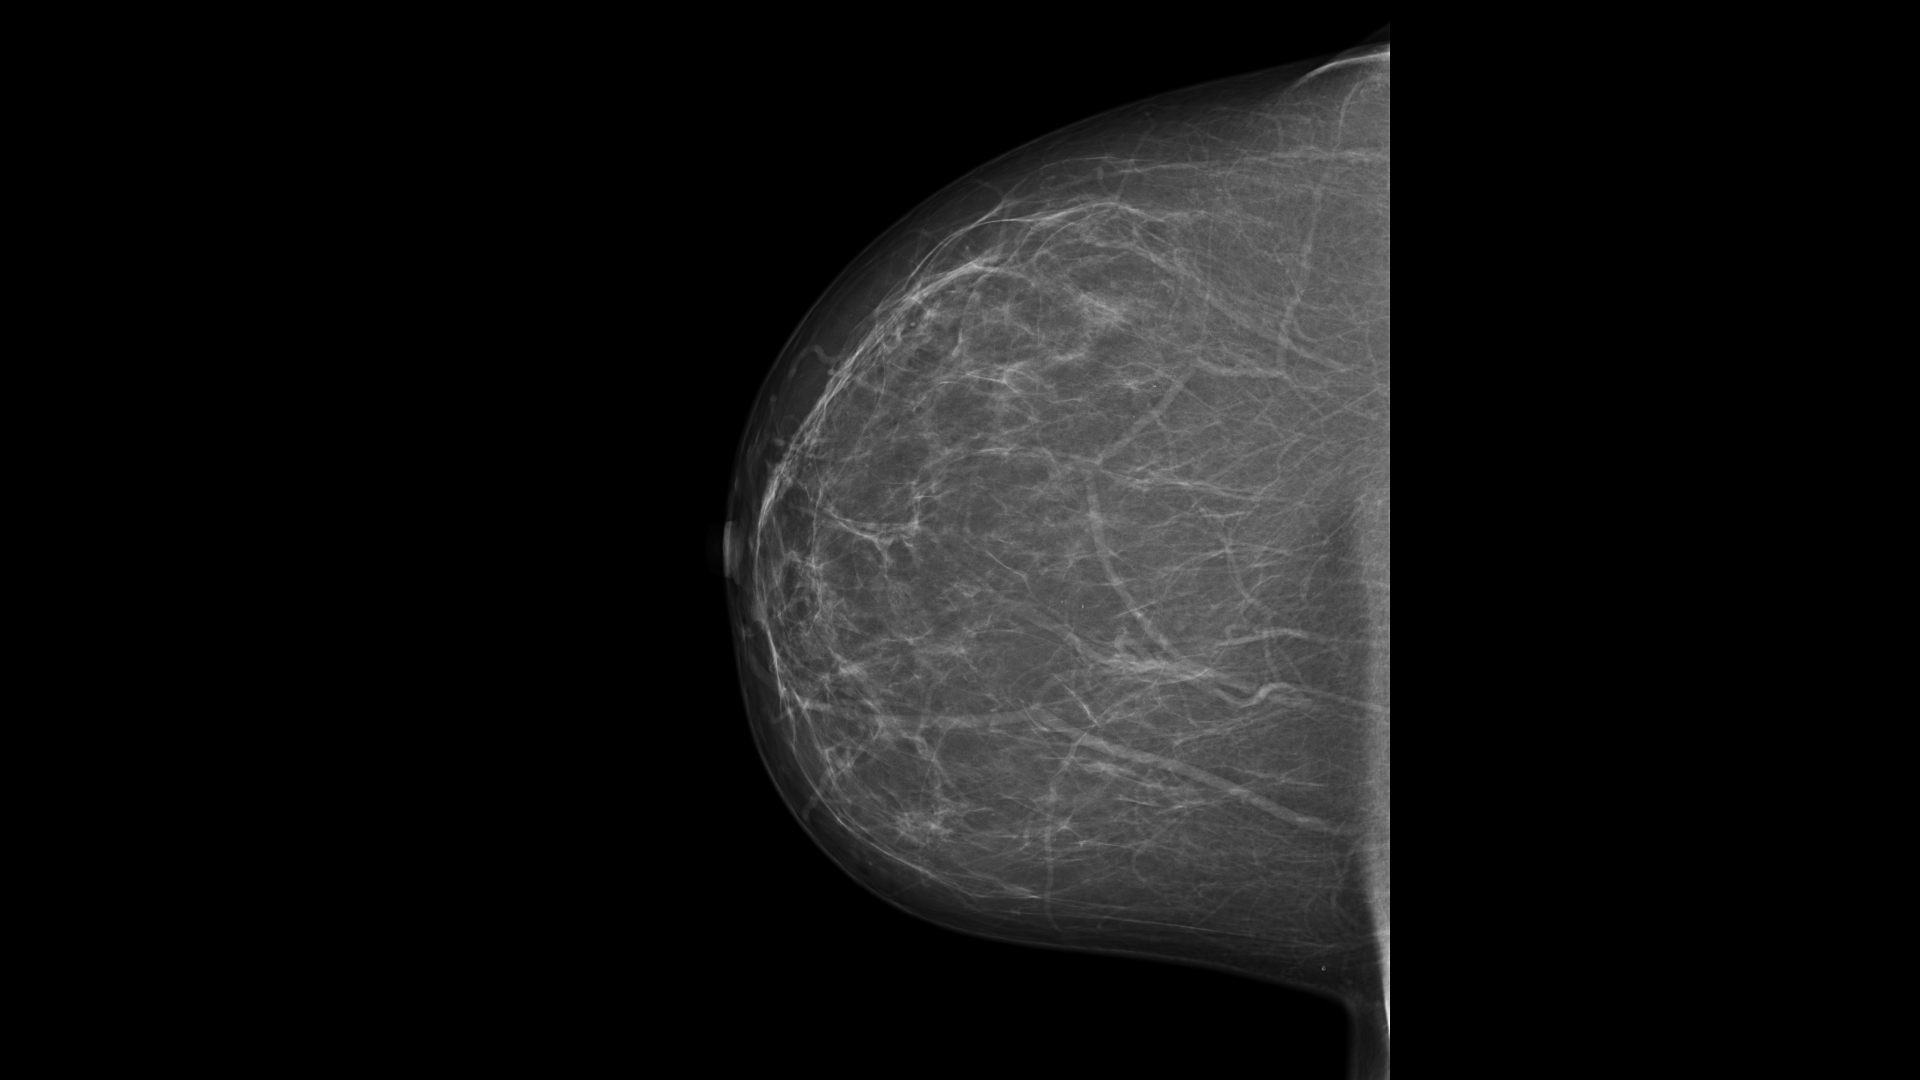

In [11]:
val_ds[0]['image']

Resolving data files:   0%|          | 0/745 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 596
})
Dataset({
    features: ['image', 'label'],
    num_rows: 149
})


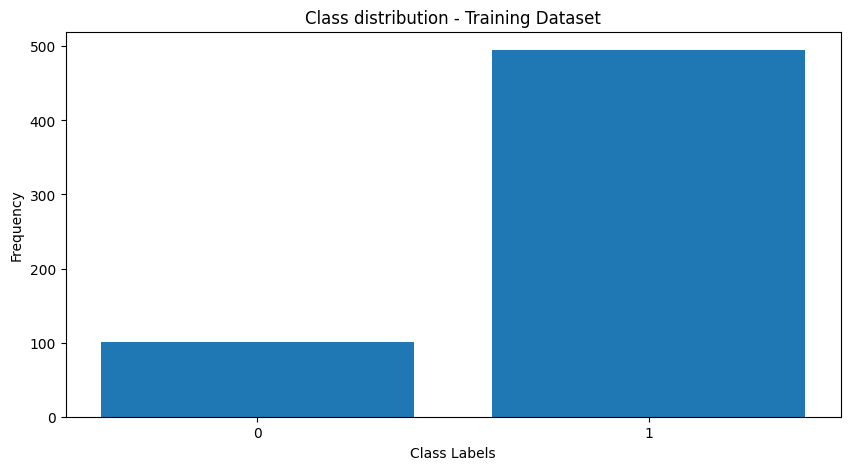

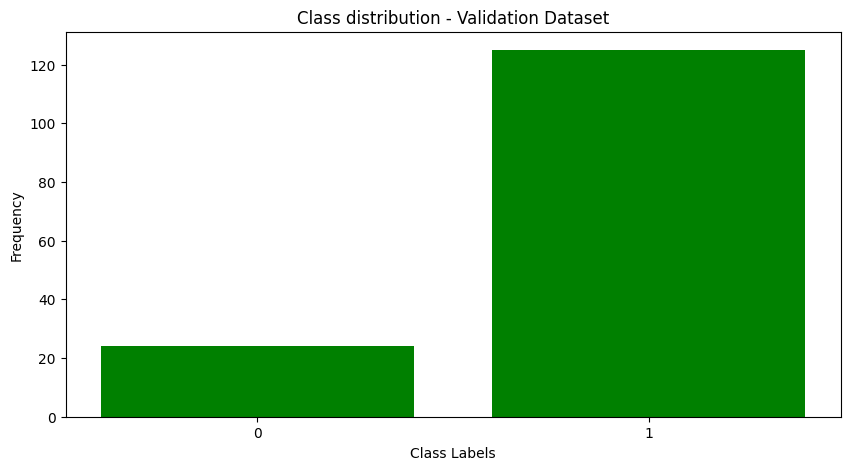

{'Cancer': 0, 'Non-Cancer': 1}
{0: 'Cancer', 1: 'Non-Cancer'}


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-08-22 15:55:44.763698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 15:55:44.763850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 15:55:44.891857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/trainin

Epoch,Training Loss,Validation Loss,Accuracy
1,0.403000,0.275144,0.838926
2,0.283400,0.179811,0.939597
3,0.216400,0.138942,0.979866


Validation Loss: 0.1389
Validation Accuracy: 0.9799
Testing Accuracy: 0.9799


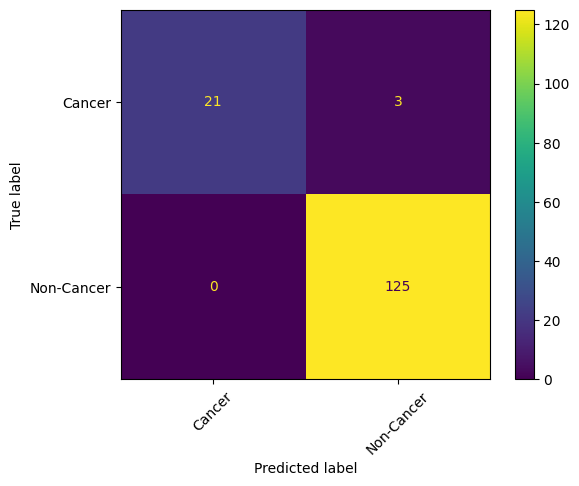

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset, load_metric
from collections import Counter

# Set random seed for reproducibility
import random
random.seed(10)

# Load dataset
dataset = load_dataset(
    "imagefolder",
    data_dir="/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset",
    split='train'
)

# Split dataset
splits = dataset.train_test_split(test_size=0.2, seed=30, shuffle=True)
train_ds = splits['train']
val_ds = splits['test']

print(train_ds)
print(val_ds)

# Obtain the labels of each dataset
train_labels = [x['label'] for x in train_ds]
val_labels = [x['label'] for x in val_ds]

# Calculate the frequency of each label
train_counter = Counter(train_labels)
val_counter = Counter(val_labels)

# Plotting class distribution for train_ds
plt.figure(figsize=(10, 5))
plt.bar(train_counter.keys(), train_counter.values())
plt.title('Class distribution - Training Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(list(train_counter.keys()))
plt.show()

# Plotting class distribution for val_ds
plt.figure(figsize=(10, 5))
plt.bar(val_counter.keys(), val_counter.values(), color='g')
plt.title('Class distribution - Validation Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(list(val_counter.keys()))
plt.show()

# Prepare label mapping
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(label2id)
print(id2label)

# Define transformations
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)

# Define processor (dummy values for illustration; replace with actual ones)
class DummyProcessor:
    def __init__(self):
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.size = {"height": 224, "width": 224}

processor = DummyProcessor()
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    id2label=id2label,
    label2id=label2id
)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "brain_tumor_detection_v12",
    save_strategy="no",  # Disable saving checkpoints
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to='tensorboard',
    remove_unused_columns=False,
    logging_steps=10,  # Log metrics every 10 steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

# Train the model
train_results = trainer.train()

# Evaluate the model
eval_results = trainer.evaluate(val_ds)
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")

# Get predictions and compute testing accuracy
test_results = trainer.predict(val_ds)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)

# Calculate and print testing accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# Display plots
plt.show()

In [3]:
dataset = load_dataset(
    "imagefolder",
    data_dir="/kaggle/input/mamography/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Original Dataset",
    split='train'
)

Resolving data files:   0%|          | 0/745 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
from collections import Counter
splits = dataset.train_test_split(test_size=0.2, seed=30, shuffle=True)
train_ds = splits['train']
val_ds = splits['test']

print(train_ds)
print(val_ds)

# Obtain the labels of each dataset
train_labels = [x['label'] for x in train_ds]
val_labels = [x['label'] for x in val_ds]

# Calculate the frequency of each label
train_counter = Counter(train_labels)
val_counter = Counter(val_labels)

Dataset({
    features: ['image', 'label'],
    num_rows: 596
})
Dataset({
    features: ['image', 'label'],
    num_rows: 149
})


In [5]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(label2id)
print(id2label)

{'Cancer': 0, 'Non-Cancer': 1}
{0: 'Cancer', 1: 'Non-Cancer'}


2024-08-22 19:30:43.602216: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 19:30:43.602335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 19:30:43.741057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.350800,0.245482,0.912752
2,0.269300,0.193251,0.959732
3,0.180900,0.303853,0.859060
4,0.222500,0.075875,0.973154
5,0.244600,0.034255,0.993289
6,0.108000,0.024650,0.993289
7,0.283200,0.025381,0.986577
8,0.135900,0.028182,0.993289
9,0.140400,0.056047,0.979866
10,0.179700,0.049648,0.979866


Validation Loss: 0.0496
Validation Accuracy: 0.9799
Testing Accuracy: 0.9799


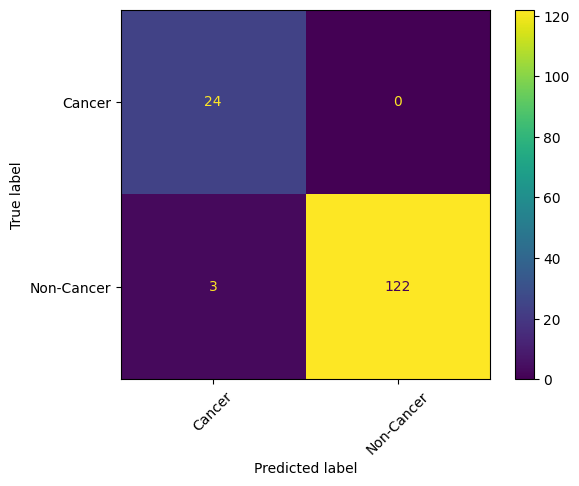

In [11]:
from transformers import SwinForImageClassification
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)
class DummyProcessor:
    def __init__(self):
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.size = {"height": 224, "width": 224}

processor = DummyProcessor()
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from transformers import ViTForImageClassification

model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-tiny-patch4-window7-224',  # You can also try other variants like 'swin-base-patch4-window7-224'
    num_labels=len(label2id),  # Number of output classes
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "breast_cancer_detection_v12",
    save_strategy="no",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to='tensorboard',
    remove_unused_columns=False,
    logging_steps=10,  # Log metrics every 10 steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
train_results = trainer.train()
eval_results = trainer.evaluate(val_ds)
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
test_results = trainer.predict(val_ds)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.224700,0.128750,0.966443
2,0.142600,0.086631,0.973154
3,0.110400,0.048648,0.986577
4,0.171400,0.040041,0.993289
5,0.160800,0.042177,0.986577


Validation Loss: 0.0422
Validation Accuracy: 0.9866
Testing Accuracy: 0.9866


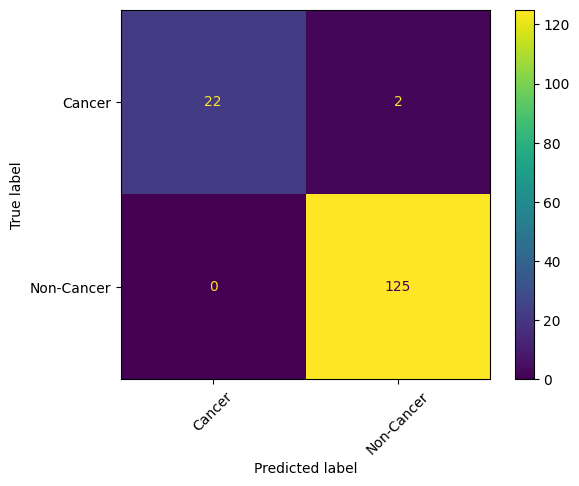

In [7]:
from transformers import DeiTForImageClassification
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)
class DummyProcessor:
    def __init__(self):
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.size = {"height": 224, "width": 224}

processor = DummyProcessor()
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from transformers import ViTForImageClassification

model = DeiTForImageClassification.from_pretrained(
    'facebook/deit-base-distilled-patch16-224',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "breast_cancer_detection_v12",
    save_strategy="no",
    evaluation_strategy="epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to='tensorboard',
    remove_unused_columns=False,
    logging_steps=10,  # Log metrics every 10 steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
train_results = trainer.train()
eval_results = trainer.evaluate(val_ds)
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
test_results = trainer.predict(val_ds)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.436400,0.373788,0.838926
2,0.283000,0.177280,0.959732
3,0.193400,0.092386,0.979866
4,0.240300,0.179602,0.953020
5,0.270000,0.138704,0.959732
6,0.189900,0.122246,0.966443
7,0.311600,0.104763,0.973154
8,0.233600,0.071594,0.973154
9,0.222500,0.054704,0.979866
10,0.285400,0.060966,0.979866


Validation Loss: 0.0610
Validation Accuracy: 0.9799
Testing Accuracy: 0.9799


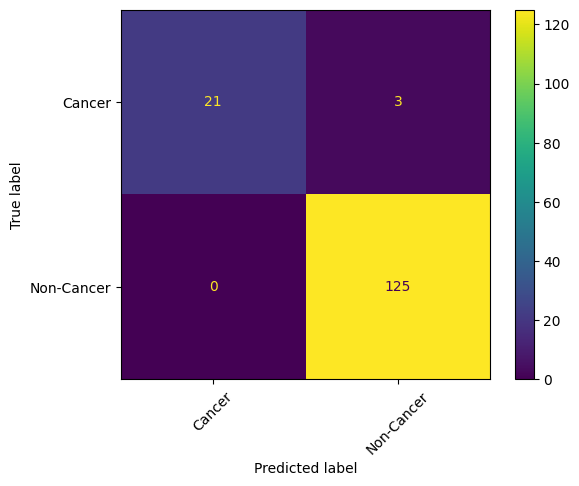

In [9]:
from transformers import BeitForImageClassification
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)
class DummyProcessor:
    def __init__(self):
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.size = {"height": 224, "width": 224}

processor = DummyProcessor()
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from transformers import ViTForImageClassification

model = BeitForImageClassification.from_pretrained(
    'microsoft/beit-base-patch16-224-pt22k-ft22k',  # You can also explore 'beit-large-patch16-224'
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "breast_cancer_detection_v12",
    save_strategy="no",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to='tensorboard',
    remove_unused_columns=False,
    logging_steps=10,  # Log metrics every 10 steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
train_results = trainer.train()
eval_results = trainer.evaluate(val_ds)
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
test_results = trainer.predict(val_ds)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.491800,0.373264,0.838926
2,0.380000,0.291074,0.838926
3,0.305100,0.205558,0.879195
4,0.257600,0.158564,0.953020
5,0.232700,0.133053,0.953020
6,0.211900,0.108500,0.966443
7,0.194800,0.094273,0.973154
8,0.182100,0.089076,0.959732
9,0.173600,0.083133,0.973154
10,0.173100,0.081786,0.973154


Validation Loss: 0.0818
Validation Accuracy: 0.9732
Testing Accuracy: 0.9732


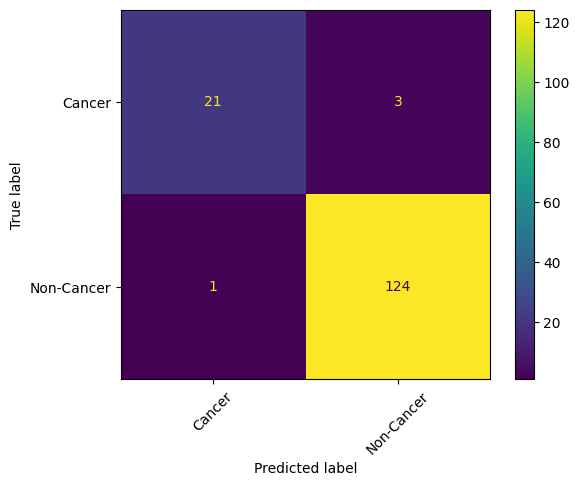

In [12]:
from transformers import ConvNextForImageClassification
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)
class DummyProcessor:
    def __init__(self):
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.size = {"height": 224, "width": 224}

processor = DummyProcessor()
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from transformers import ViTForImageClassification

model = ConvNextForImageClassification.from_pretrained(
    'facebook/convnext-tiny-224',  # You can also try other variants like 'convnext-base-224'
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "breast_cancer_detection_v12",
    save_strategy="no",
    evaluation_strategy="epoch",
    learning_rate=6e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.001,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to='tensorboard',
    remove_unused_columns=False,
    logging_steps=10,  # Log metrics every 10 steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)
train_results = trainer.train()
eval_results = trainer.evaluate(val_ds)
print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
test_results = trainer.predict(val_ds)
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")
labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()